In [1]:
import os
import pandas as pd
import numpy as np
from rlgym.rocket_league.sim import RocketSimEngine
from rlgym.api import RLGym
import RocketSim as rsim
from rlgym_tools.rocket_league.replays.parsed_replay import ParsedReplay, process_replay
from rlgym.rocket_league.common_values import (
    BLUE_TEAM,
    ORANGE_TEAM,
    BLUE_GOAL_CENTER,
    ORANGE_GOAL_CENTER,
    GOAL_THRESHOLD,
    GOAL_HEIGHT,
    GOAL_CENTER_TO_POST,
    CEILING_Z
)
import rlgym.rocket_league.math as rlmath
from rlgym.rocket_league.api import GameState

In [2]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from scipy import ndimage
import matplotlib.image as mpimg

In [3]:
sim = RocketSimEngine()
sim.close()

In [4]:
replay = ParsedReplay.load("bds-g2.replay")

In [5]:
replay.metadata["game"]["goals"]

[{'frame': 3475, 'player_name': 'dralii', 'is_orange': False},
 {'frame': 3817, 'player_name': 'BeastMode', 'is_orange': True},
 {'frame': 7046, 'player_name': 'dralii', 'is_orange': False},
 {'frame': 7863, 'player_name': 'Daniel', 'is_orange': True},
 {'frame': 9996, 'player_name': 'dralii', 'is_orange': False}]

In [6]:
def plot_field():
    fig, ax = plt.subplots()
    img = mpimg.imread("field.jpeg")
    img = ndimage.rotate(img, angle=90)
    ax.imshow(img, extent=[-4150,4100,-6250,6200])
    return fig, ax

In [7]:
def rectangle_sdf(pos, halfsize):
    halfsize = np.array(halfsize)
    edge_distance = np.abs(pos) - halfsize
    return np.sum(rlmath.magnitude(np.maximum(edge_distance, 0)))

In [8]:
def distance_to_goal(pos, team):
    if team:
        goal_pos = ORANGE_GOAL_CENTER
        y_offset = GOAL_THRESHOLD
    else:
        goal_pos = BLUE_GOAL_CENTER
        y_offset = -GOAL_THRESHOLD
    
    offset = np.array(goal_pos)
    offset[1] += y_offset
    halfsize = [
        GOAL_CENTER_TO_POST,
        GOAL_THRESHOLD,
        GOAL_HEIGHT / 2
    ]
    
    return rectangle_sdf(pos - offset, halfsize)

In [9]:
x = np.linspace(-4000, 4000, 100)
y = np.linspace(-6000, 6000, 100)
X, Y = np.meshgrid(x, y)

In [10]:
def plot_distance_field(team, levels=[]):
    def _distance(x, y):
      return distance_to_goal([x, y, 0], team)
    v_dist = np.vectorize(_distance)
        
    x = np.linspace(-4000, 4000, 100)
    y = np.linspace(-6000, 6000, 100)
    X, Y = np.meshgrid(x, y)
    Z = v_dist(X, Y)
    fig, ax = plot_field()
    ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')
    cb = fig.colorbar(ct, ax=ax)
    cb.set_label("Distance (uu)")
    return fig, ax
    
    

In [11]:
def detect_shot_callback(state, team, iter, threshold=200):
    ball_pos = [state["x"], state["y"], state["z"]]
    dist = distance_to_goal(ball_pos, not team)
    # print(f"Distance to goal: {dist}")
    if dist == 0.0:
        print(f"Goal!")
        return True
    if dist < threshold:
        print(f"Shot Detected!")
    return

In [12]:
def detect_shot(pos, team, threshold=500):
    dist = distance_to_goal(pos, not team)
    if dist < threshold:
        return True
    return False

In [13]:
def sim_detect_shot(ball_data, arena, time_s=1):
    is_shot = False
    team = ball_data["hit_team_num"]
    if team:
        goal_dir = 1
    else:
        goal_dir = -1
    
    tick_rate = round(arena.tick_rate)
    ticks = round(tick_rate*time_s)
    
    ball_pos = ball_data[["pos_x", "pos_y", "pos_z"]].to_numpy()
    ball_vel = ball_data[["vel_x", "vel_y", "vel_z"]].to_numpy()
    ball_ang_vel = ball_data[["ang_vel_x", "ang_vel_y", "ang_vel_z"]].to_numpy()
    ball_quat = ball_data[["quat_w", "quat_x", "quat_y", "quat_z"]].to_numpy()
    ball_state = rsim.BallState()
    ball_state.pos = rsim.Vec(*ball_pos)
    ball_state.vel = rsim.Vec(*ball_vel)
    ball_state.ang_vel = rsim.Vec(*ball_ang_vel)
    try:
        ball_state.rot_mat = rsim.RotMat(*rlmath.quat_to_rot_mtx(ball_quat).transpose().flatten())
    except ValueError:
        pass
    arena.ball.set_state(ball_state)
    ball_sim_data = []
    for i in range(ticks):
        arena.step(1)
        next_state = arena.ball.get_state()
        
        is_shot = detect_shot(next_state.pos, team)
        current_ball_state = {"shot": is_shot}
        current_ball_state.update({
            key: val for key, val in zip(["pos_x", "pos_y", "pos_z"], next_state.pos)
        })
        current_ball_state.update({
            key: val for key, val in zip(["vel_x", "vel_y", "vel_z"], next_state.vel)
        })
        current_ball_state.update({
            key: val for key, val in zip(["ang_vel_x", "ang_vel_y", "ang_vel_z"], next_state.ang_vel)
        })
        ball_sim_data.append(current_ball_state)
        
        # Stop the simulation if hit is going away from net
        if goal_dir*next_state.vel[1] > 0:
            break
            
        # Stop the simulation if hit is detected as a shot
        if is_shot:
            break
    return pd.DataFrame(ball_sim_data)

C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


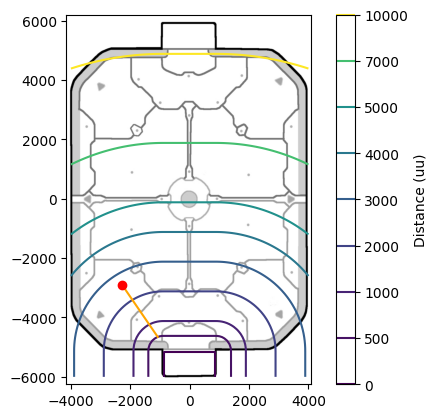

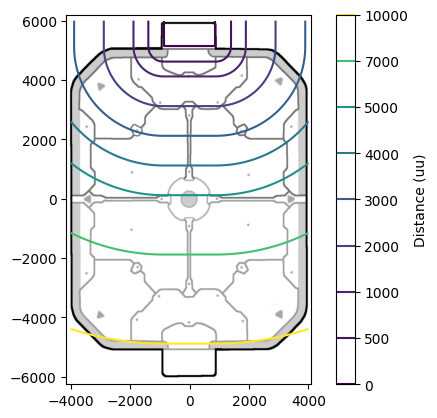

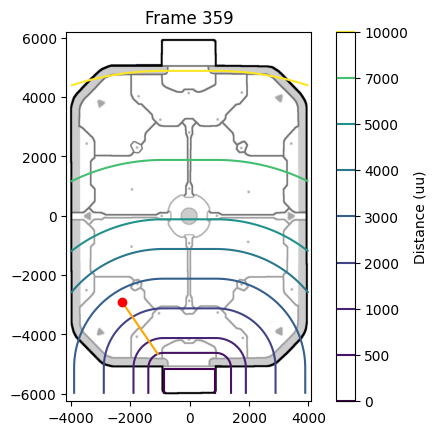

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


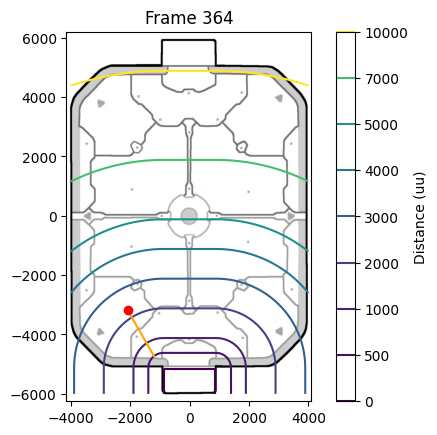

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


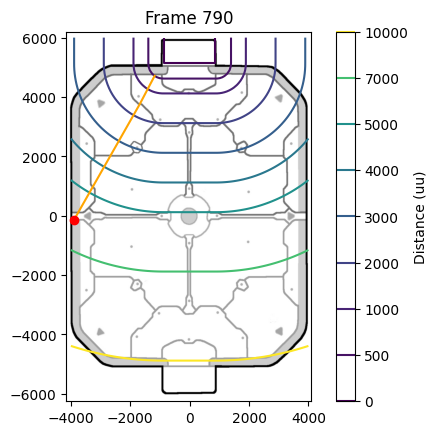

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


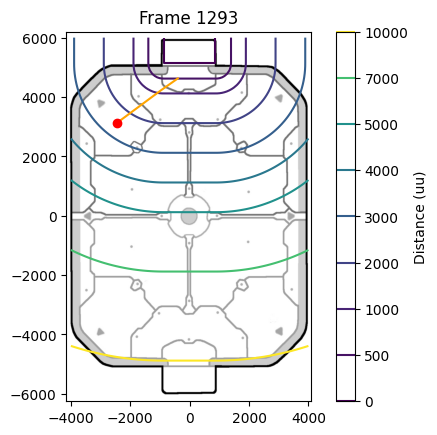

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


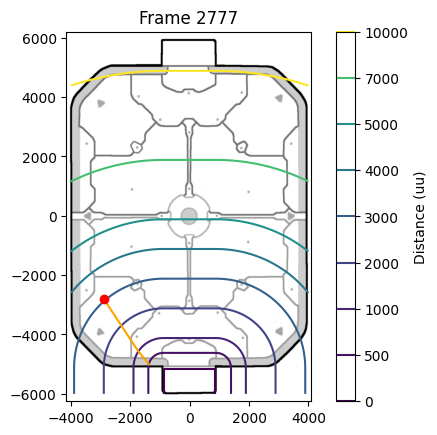

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


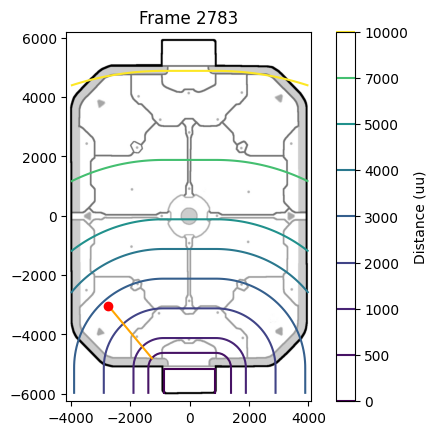

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


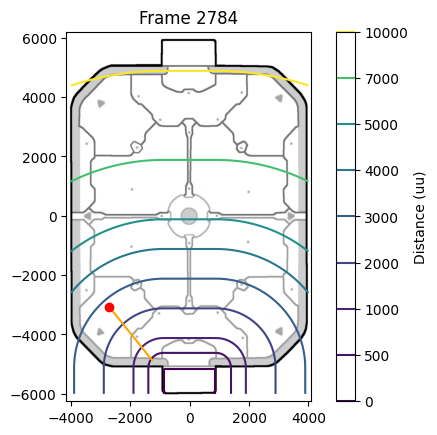

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


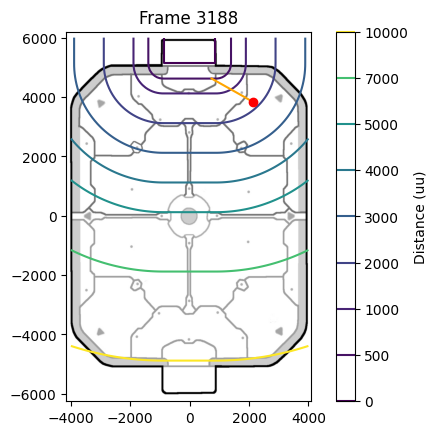

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


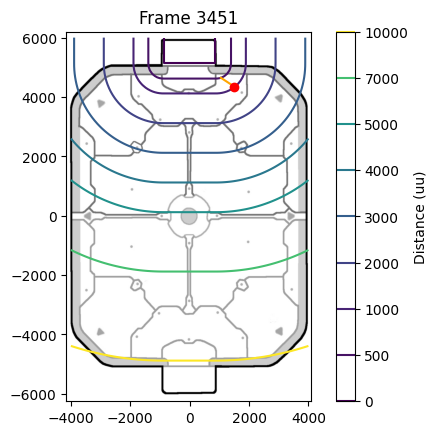

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


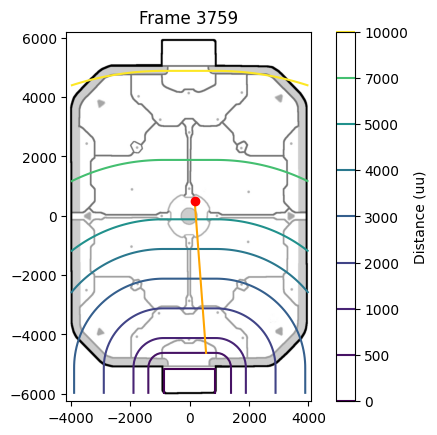

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


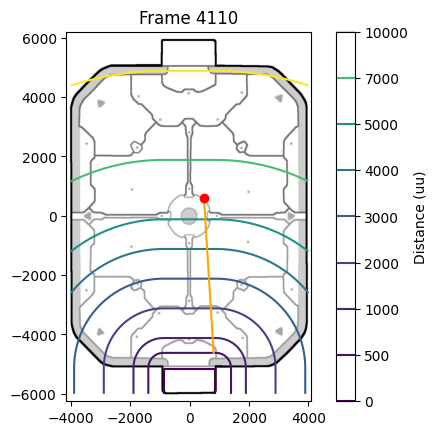

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


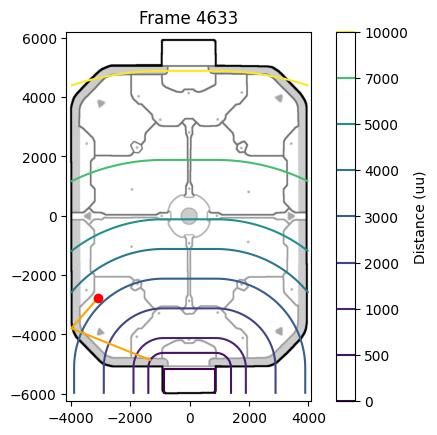

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


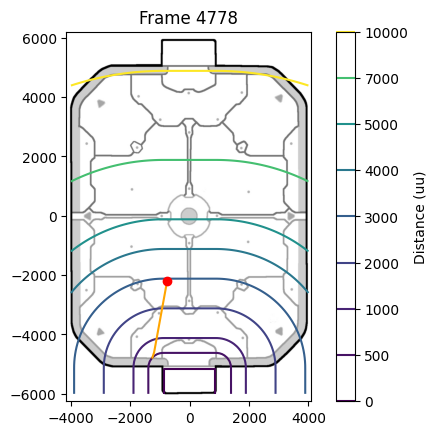

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


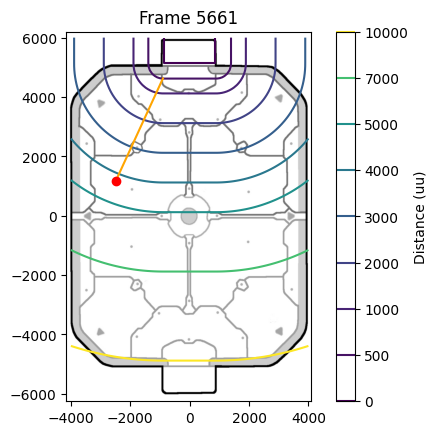

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


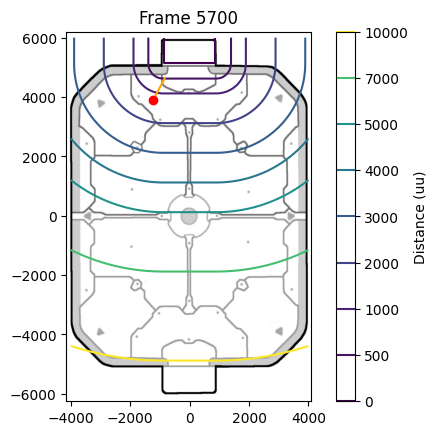

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


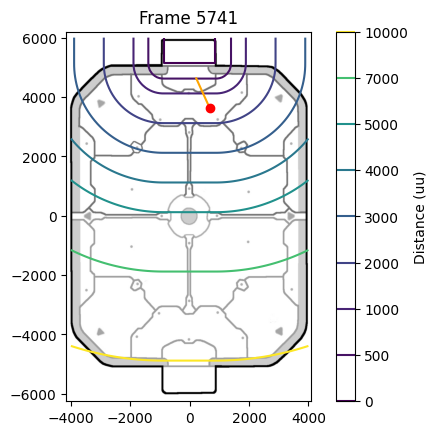

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


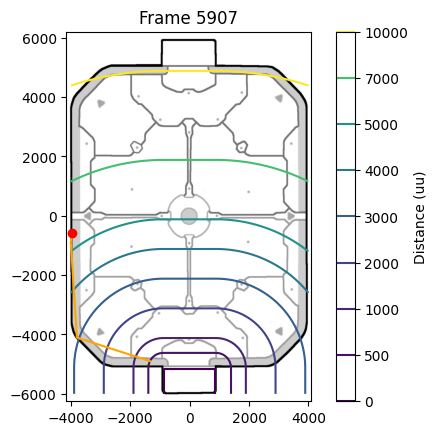

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


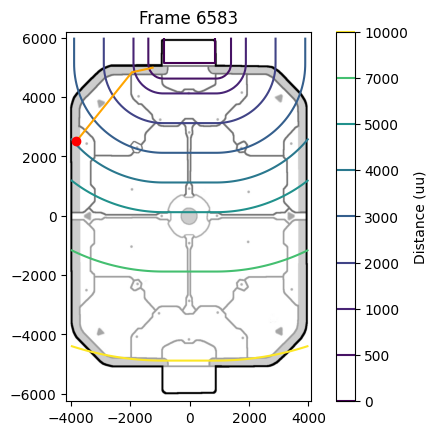

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


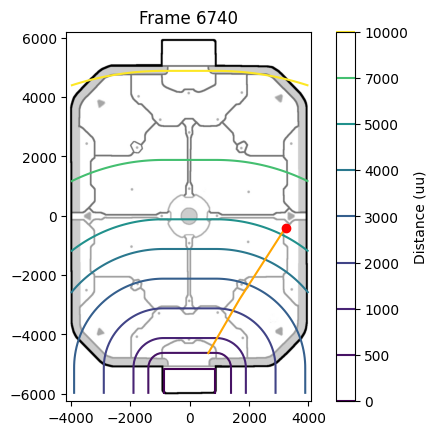

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


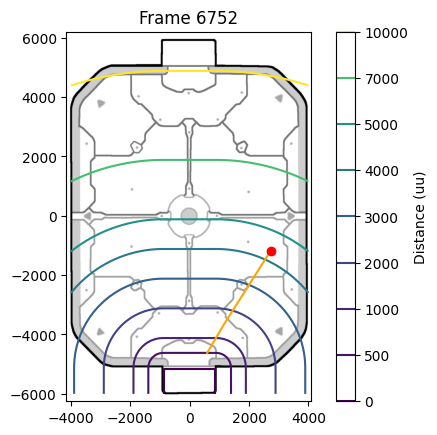

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


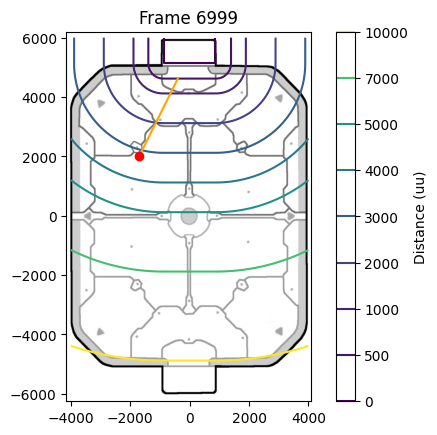

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


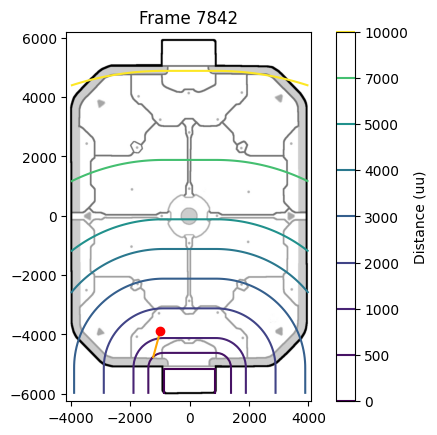

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


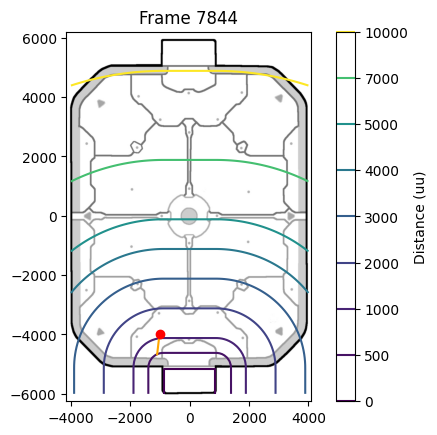

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


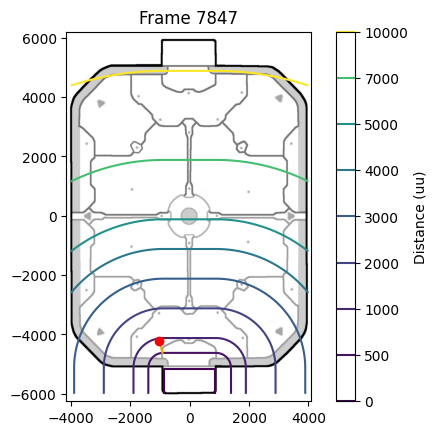

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


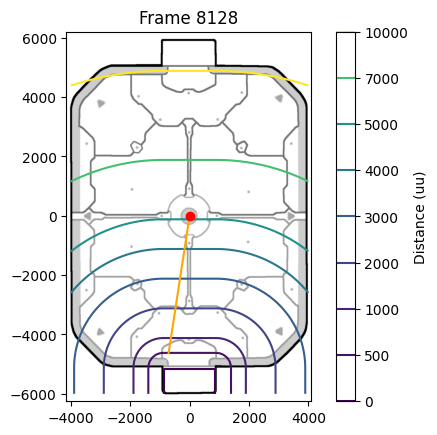

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


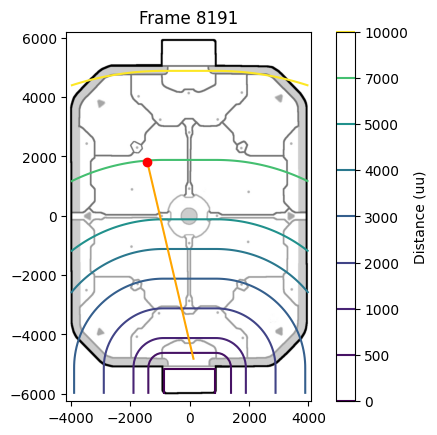

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


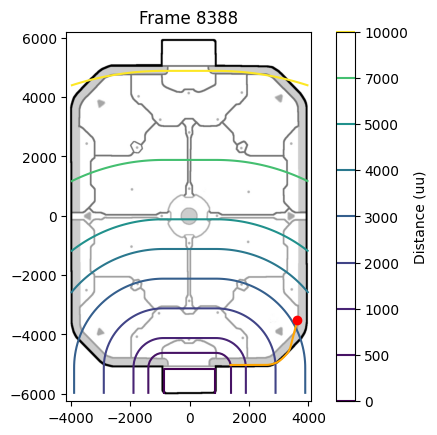

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


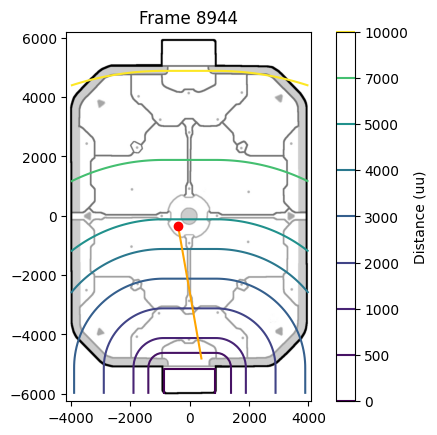

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


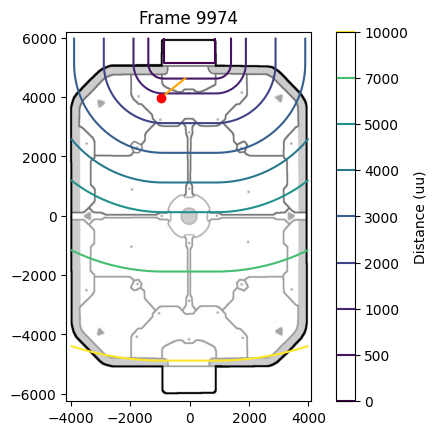

Shot detected!


C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


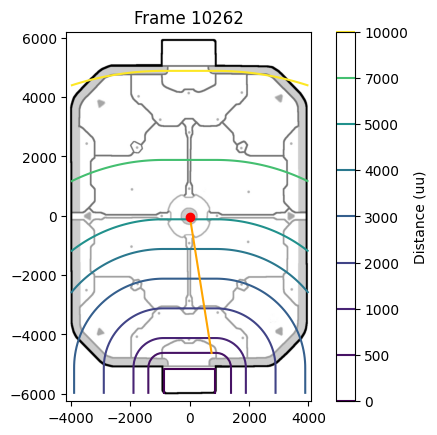

In [15]:
arena = rsim.Arena(rsim.GameMode.SOCCAR)
fig0, ax0 = plot_distance_field(
    0,
    levels=[0, 500, 1000, 2000, 3000, 4000, 5000, 7000, 10000]
)
fig1, ax1 = plot_distance_field(
    1,
    levels=[0, 500, 1000, 2000, 3000, 4000, 5000, 7000, 10000]
)
for hit in replay.analyzer["hits"]:
    hit_frame = hit["frame_number"]
    ball_state = replay.ball_df.iloc[hit_frame, :]
    team = ball_state["hit_team_num"]
    sim_df = sim_detect_shot(ball_state, arena, time_s=3)
    if sim_df.iloc[-1, :]["shot"]:
        print("Shot detected!")
        fig, ax = plot_distance_field(
            not team,
            levels=[0, 500, 1000, 2000, 3000, 4000, 5000, 7000, 10000]
        )
        if team:
            ax0.scatter(ball_state["pos_x"], ball_state["pos_y"], color="r", zorder=4)
            ax0.plot(sim_df["pos_x"], sim_df["pos_y"], color="orange", zorder=2)
        else:
            ax1.scatter(ball_state["pos_x"], ball_state["pos_y"], color="r", zorder=4)
            ax1.plot(sim_df["pos_x"], sim_df["pos_y"], color="orange", zorder=2)
        ax.scatter(ball_state["pos_x"], ball_state["pos_y"], color="r", zorder=4)
        ax.plot(sim_df["pos_x"], sim_df["pos_y"], color="orange", zorder=2)
        ax.set_title(f"Frame {hit_frame}")
        plt.show()
arena.stop()


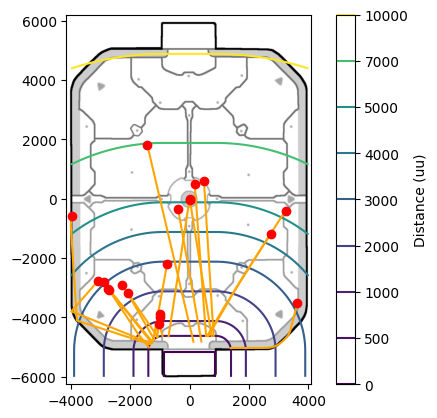

In [14]:
fig0

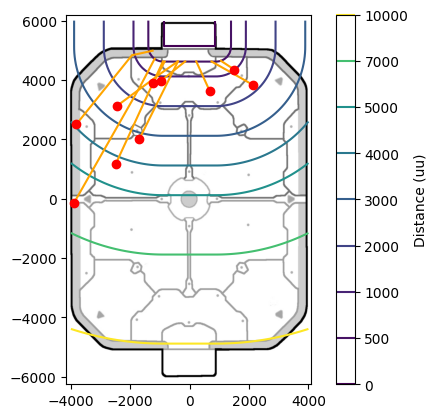

In [15]:
fig1

In [16]:
hit_df = pd.DataFrame(replay.analyzer["hits"])
hit_debug_df = pd.DataFrame(hit_df.pop("_debug_info").to_list())
hit_df.join(hit_debug_df)

,frame_number,player_unique_id,player_distance,hit_team_num_changed,ang_vel_changed,predicted_bounce,speed_increased
0,178,11174839928636389730,255.95503,True,True,False,False
1,179,12114697561242797785,149.99281,True,True,False,False
2,180,11174839928636389730,234.42358,True,True,False,False
3,208,7728916415732163168,373.54138,False,True,False,False
4,210,7728916415732163168,229.85835,False,True,False,True
...,...,...,...,...,...,...,...
276,10474,7728916415732163168,150.29587,False,True,False,False
277,10486,7728916415732163168,170.76344,False,True,False,False
278,10493,18150834425374492451,241.57669,True,True,False,False
279,10494,7728916415732163168,170.03625,True,True,False,False


In [17]:
gameplay_df = pd.DataFrame(replay.analyzer["gameplay_periods"])
gameplay_df

,start_frame,end_frame,first_hit_frame,goal_frame
0,121,3561,178,3475.0
1,3682,3904,3740,3817.0
2,4025,7133,4091,7046.0
3,7254,7950,7311,7863.0
4,8071,10083,8128,9996.0
5,10204,10564,10262,NaN


In [18]:
(hit_df["frame_number"] - gameplay_df["goal_frame"][0]).abs()

0      3297.0
1      3296.0
2      3295.0
3      3267.0
4      3265.0
        ...  
276    6999.0
277    7011.0
278    7018.0
279    7019.0
280    7069.0
Name: frame_number, Length: 281, dtype: float64

C:\Users\Violet\AppData\Local\Temp\ipykernel_7336\1699787647.py:11: UserWarning: The following kwargs were not used by contour: 'shading'
  ct = ax.contour(X, Y, Z, levels=levels, shading='auto', cmap='viridis')


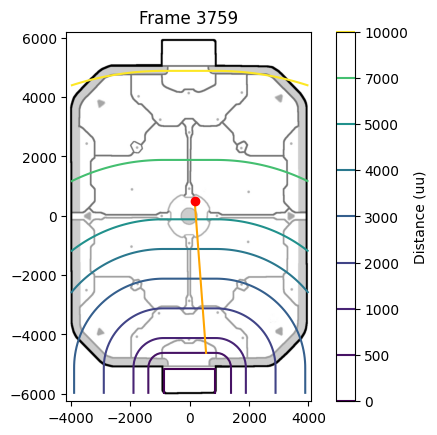

In [19]:
ball_state = replay.ball_df.iloc[3759, :]
arena = rsim.Arena(rsim.GameMode.SOCCAR)
sim_df = sim_detect_shot(ball_state, arena, time_s=3)
arena.stop()
fig, ax = plot_distance_field(
    0,
    levels=[0, 500, 1000, 2000, 3000, 4000, 5000, 7000, 10000]
)
ax.scatter(ball_state["pos_x"], ball_state["pos_y"], color="r", zorder=4)
ax.plot(sim_df["pos_x"], sim_df["pos_y"], color="orange", zorder=2)
ax.set_title(f"Frame {3759}")
plt.show()

In [20]:
np.dot(rlmath.normalize(replay.ball_df[["vel_x", "vel_y", "vel_z"]].to_numpy()[573]), [0,1,0])

0.7926279902458191